In [67]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
from tqdm import tqdm

In [68]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [69]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [70]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train':transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)               
            ]),
            'val':transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)               
            ])
        }
        
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

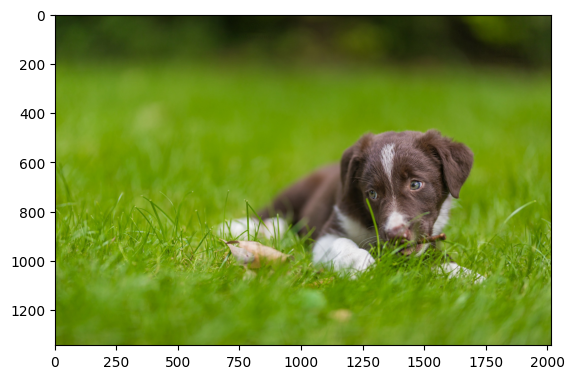

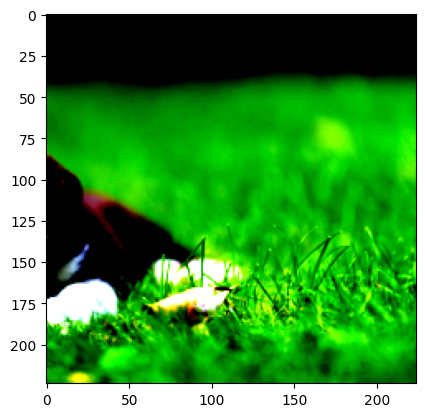

In [71]:
img_file_path = './data/cute_dog.jpg'
img = Image.open(img_file_path)

plt.imshow(img)
plt.show()

resize = 224
mean = (0.485, 0.456, 0.406) 
std = (0.229, 0.224, 0.225)
 
transform = ImageTransform(resize, mean, std)
img_transformed = transform(img, phase='train')

img_transformed = img_transformed.numpy().transpose(1,2,0)
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()


In [72]:
def make_datapath_list(phase="train"):
    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+"/**/*.jpg")
    print(target_path)
    
    path_list = [ ]
    
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list

In [73]:
path_list = make_datapath_list("train")

./data/hymenoptera_data/train/**/*.jpg


In [74]:
len(path_list)

243

In [75]:
path_list[:10]

['./data/hymenoptera_data/train\\ants\\0013035.jpg',
 './data/hymenoptera_data/train\\ants\\1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train\\ants\\1095476100_3906d8afde.jpg',
 './data/hymenoptera_data/train\\ants\\1099452230_d1949d3250.jpg',
 './data/hymenoptera_data/train\\ants\\116570827_e9c126745d.jpg',
 './data/hymenoptera_data/train\\ants\\1225872729_6f0856588f.jpg',
 './data/hymenoptera_data/train\\ants\\1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train\\ants\\1269756697_0bce92cdab.jpg',
 './data/hymenoptera_data/train\\ants\\1286984635_5119e80de1.jpg',
 './data/hymenoptera_data/train\\ants\\132478121_2a430adea2.jpg']

In [76]:
train_list = make_datapath_list("train")
val_list = make_datapath_list("val")

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


In [77]:
class MyDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img=Image.open(img_path)
        
        img_transformeda = self.transform(img, self.phase)
    
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]
            
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1
            
        return img_transformed, label

In [78]:
train_dataset = MyDataset(train_list, transform = ImageTransform(resize, mean, std), phase = "train")

In [79]:
val_dataset = MyDataset(val_list, transform = ImageTransform(resize, mean, std), phase = "val")

In [80]:
index = 0
# print(train_dataset.__len__())
img, label = train_dataset.__getitem__(index)
print(img.shape)
print(label)

(224, 224, 3)
0


In [81]:
batch_size = 4

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle = False)

dataloader_dict = {"train":train_dataloader,"val":val_dataloader}


In [82]:
batch_iterator = iter(dataloader_dict["train"])
inputs, labels = next(batch_iterator)

In [83]:
print(inputs.size()) # inputs.shape
print(labels)

torch.Size([4, 224, 224, 3])
tensor([0, 1, 0, 0])


# Network

In [84]:
use_pretrained = True
net = models.vgg16(pretrained = use_pretrained)
net.classifier[6] = nn.Linear(in_features = 4096, out_features = 2)
# print(net)

# setting mode
net.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## loss

In [85]:
criterior = nn.CrossEntropyLoss()

## optimizer

In [86]:
params_to_update = []

update_params_name = ['classifier.6.weight', 'classifier.6.bias']

for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad =True
        params_to_update.append(param)
    else:
        param.requires_grad = False
        
print(params_to_update)

[Parameter containing:
tensor([[-0.0128,  0.0132,  0.0116,  ..., -0.0050,  0.0111,  0.0068],
        [ 0.0078, -0.0020, -0.0055,  ..., -0.0129, -0.0034, -0.0071]],
       requires_grad=True), Parameter containing:
tensor([ 0.0061, -0.0030], requires_grad=True)]


In [87]:
optimizer = optim.SGD(params = net.parameters(), lr = 0.001, momentum=0.9)

In [88]:
def train_model(net,dataloader_dict, criterior, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        
        for phase in ["train", "val"]:
            if phase == "train":
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            if(epoch == 0) and (phase == "train"):
                continue
            for inputs, labels in tqdm(dataloader_dict[phase]):
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase=="train"):
                    outputs = net(inputs)
                    loss = criterior(outputs, labels)
                    _, preds=torch.max(outputs,1)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item()*inputs.size(0)
                    epoch_corrects += torch.sum(preds==labels.data)
                    
                epoch_loss = epoch_loss/len(dataloader_dict[phase].dataset)
                epoch_accuracy = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
                
                print("{} Loss: {:.4f} Acc: {:.4f}".format(phase,epoch_loss, epoch_accuracy))
                    

In [89]:
num_epochs = 2
train_model(net, dataloader_dict, criterior, optimizer, num_epochs)

Epoch 0/2


  0%|          | 0/39 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[4, 224, 224, 3] to have 3 channels, but got 224 channels instead